Workflows are super important as if we want to implement some of the usecases and for that particular usecases, when we are designing a workflow, we can follow some specific patterns in order to solve that complex problem.
- Prompt Chaining
- Parallelization

## Prompt Chaining
- It is a technique in natural language processing where **multiple prompts are sequenced together to guide a model through a complex task or reasoning process.**
- Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one.
- This approach can improve accuracy, coherence and control when working with large language models.

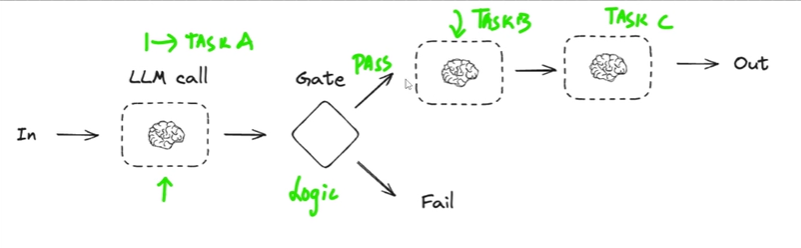

### How Prompt Chaining works with LangGraph
1. **Define the task:** start by breaking down the problem into smaller sub-tasks. Ex- if you want to generate a detailed report, you might split it into steps like "gather data", "analyze data", and 'write summary"
2. **Create Nodes:** each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text"
3. **Establish Edges:** edges define the sequence and dependencies betwwen nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.
4. **Execute the Graph:** LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.
5. **Iterate if needed:** LangGraph supports conditional logic and loops, so you can revisit eariler nodes or adjust the flow based on the intermediate results.

#### Usecase: Generate a Story
if condition passes then improve the story then polish it else re-generate 

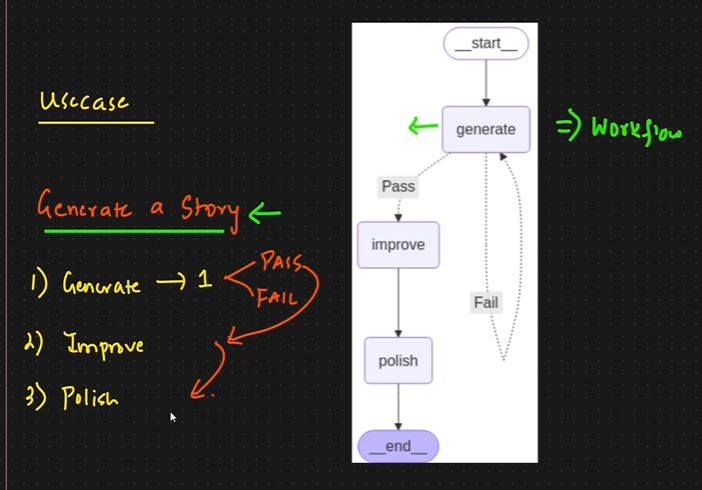

In [ ]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In empty halls, I stand alone,\nEchoes of memories, a distant moan.\nThe darkness whispers, a lonely sigh,\nA heart that beats, with a lonely cry.\n\nThe world outside, a bustling throng,\nI'm lost in shadows, where love has gone.\nA solitary figure, in a crowded space,\nA soul that yearns, for a friendly face.\n\nThe silence screams, a deafening sound,\nA loneliness that wraps me around.\nBut still I hold, onto a glimmer of hope,\nA light that shines, in the dark of scope.\n\nFor in the stillness, I find my voice,\nA whispered promise, to make a joyful choice.\nTo rise above, the emptiness and pain,\nAnd find my way, through the darkness and the rain."

In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    story: str
    improved_story: str
    final_story: str

In [8]:
def generate_story(state:State):
    story=groq_llm.invoke(f"write a short story about {state['topic']}")
    return {'story':story.content}

def route_condition(state:State):
    if '?' in state['story'] or '!' in state['story']:
        return "Fail"
    return "Pass"

def improve_story(state:State):
    story=groq_llm.invoke(f'Enhance the story with valid details: {state['story']}')
    return {'improved_story':story.content}

def final_story(state:State):
    story=groq_llm.invoke(f'Add a twist at the end of the story: {state['improved_story']}')
    return {'final_story':story.content}

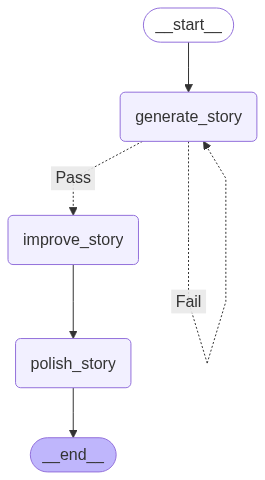

In [9]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

# add nodes
graph.add_node("generate_story",generate_story)
graph.add_node("improve_story",improve_story)
graph.add_node("polish_story",final_story)

# add edges
graph.add_edge(START,'generate_story')
graph.add_conditional_edges('generate_story',route_condition,{"Pass":'improve_story',"Fail":'generate_story'})
graph.add_edge('improve_story','polish_story')
graph.add_edge('polish_story',END)

agent=graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
agent.invoke({'topic':'alone'})

{'topic': 'alone',
 'story': '**The Island of Solitude**\n\nAs I stepped off the small wooden boat, the warm sand cradled beneath my feet. I felt a sense of relief wash over me, a sense of freedom from the constraints of the world. I had been searching for this moment for what felt like an eternity, and finally, I had found it.\n\nI stood tall, surveying my new surroundings. The island was small, no larger than a few acres, with a dense thicket of palm trees and a crescent-shaped beach. The air was thick with the sweet scent of blooming flowers and the sound of waves crashing against the shore.\n\nI had come to this place to escape, to flee the noise and chaos of the world. I had grown tired of the constant din of voices, the endless stream of faces, and the weight of expectations. I had grown tired of being alone in a crowded world.\n\nAs I walked along the beach, I felt a sense of peace settle over me. The island was alive, yet eerily quiet. The only sound was the gentle lapping of t

#### Benefits of Prompt Chaining
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.
- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.
- Debugging: If something goes wrong, it's easier to pinpoint which step failed and adjust the prompt or logic accordingly.
- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.

## Parallelization
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don't depend on each other's outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently
- Connecting them to a common starting point (eg. START or another node)
- Merging their outputs into a downstream node if needed

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (eg. Python's asyncio or a multi-threaded executor)

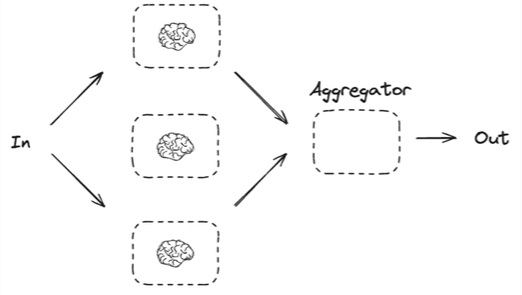

### Usecase: 
Generate a story having different characters, premise, plots and setting and at last combine all to get final story

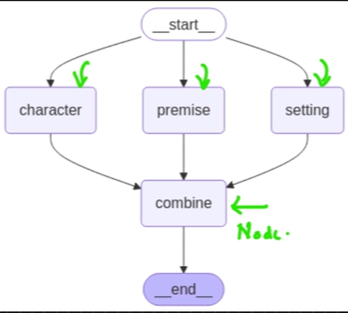

In [11]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In empty halls I wander free,\nA solitary soul, lost in me.\nThe world outside is full of sound,\nBut in my heart, silence is found.\n\nThe shadows dance upon the wall,\nA lonely figure, beyond recall.\nI search for connection, a gentle hand,\nBut in the night, I'm left to stand.\n\nAlone I face the darkest night,\nA single star, a lonely light.\nYet in this solitude, I find my space,\nA quiet refuge, a peaceful place."

In [14]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    characters: str
    premises: str
    settings: str
    story: str

In [15]:
def characters(state:State):
    """Generate character descriptions"""
    msg=groq_llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {'characters':msg.content}

def premises(state:State):
    """Generate a stroy premise"""
    msg=groq_llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {'premises':msg.content}

def settings(state:State):
    """Generate a stroy setting"""
    msg=groq_llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {'settings':msg.content}

def combine_story(state:State):
    """combine characters, premises, settings into an intro of a story"""
    msg=groq_llm.invoke(f"""
Write a short story introduction using these elements:\n
                        Characters: {state['characters']}\n
                        Premise: {state['premises']}\n
                        Setting: {state['settings']}\n
""")
    return {'story':msg.content}

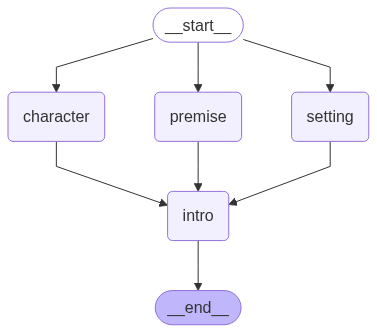

In [16]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

# add nodes
graph.add_node('character',characters)
graph.add_node('premise',premises)
graph.add_node('setting',settings)
graph.add_node('intro',combine_story)

# add edges
graph.add_edge(START,'character')
graph.add_edge(START,'premise')
graph.add_edge(START,'setting')
graph.add_edge('character','intro')
graph.add_edge('premise','intro')
graph.add_edge('setting','intro')
graph.add_edge('intro',END)

agent=graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [17]:
agent.invoke({'topic':'marvels'})

{'topic': 'marvels',
 'characters': "Here are two character names and brief traits for a Marvels story:\n\n1. **Name:** Astrid Nova\n**Age:** 25\n**Appearance:** Astrid is a petite, athletic woman with short, spiky hair that shifts between different shades of indigo, depending on her mood. Her eyes are an piercing blue.\n**Powers:** Astrid has the ability to control and manipulate light across the electromagnetic spectrum. She can create blindingly bright beams of light, project holographic images, or even fly by propelling herself with her light-based powers.\n**Personality:** Astrid is a free-spirited adventurer who loves taking risks and pushing herself to the limit. She's fiercely independent and can come across as aloof or standoffish to those who don't know her.\n\n2. **Name:** Ethan Orion\n**Age:** 30\n**Appearance:** Ethan is a tall, broad-shouldered man with short, dark hair and piercing green eyes. He has a series of intricate, glowing tattoos on his arms and torso that refle

#### Benefits of Parallelization
- Speed: reduces total execution time by running tasks concurrently
- Scalability: handling larger workflows efficiently
- Modularity: keeps the graph structure clean and reusable

#### Key Takeaways
- When to parallelize: use it for independent tasks (eg. generating multiple outputs, checking separate inputs)
- Merging: downstream nodes can aggregate parallel results
- LangGraph Support: the framework naturally supports this by waiting for all the required inputs before proceeding